In [1]:
# Import our dependencies
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,OneHotEncoder
import pandas as pd
import tensorflow as tf

In [2]:
#  Import and read the charity_data.csv.
application_df = pd.read_csv("charity_data.csv")
application_df.head()

,EIN,NAME,APPLICATION_TYPE,AFFILIATION,CLASSIFICATION,USE_CASE,ORGANIZATION,STATUS,INCOME_AMT,SPECIAL_CONSIDERATIONS,ASK_AMT,IS_SUCCESSFUL
0,10520599,BLUE KNIGHTS MOTORCYCLE CLUB,T10,Independent,C1000,ProductDev,Association,1,0,N,5000,1
1,10531628,AMERICAN CHESAPEAKE CLUB CHARITABLE TR,T3,Independent,C2000,Preservation,Co-operative,1,1-9999,N,108590,1
2,10547893,ST CLOUD PROFESSIONAL FIREFIGHTERS,T5,CompanySponsored,C3000,ProductDev,Association,1,0,N,5000,0
3,10553066,SOUTHSIDE ATHLETIC ASSOCIATION,T3,CompanySponsored,C2000,Preservation,Trust,1,10000-24999,N,6692,1
4,10556103,GENETIC RESEARCH INSTITUTE OF THE DESERT,T3,Independent,C1000,Heathcare,Trust,1,100000-499999,N,142590,1


In [4]:
# Drop the non-beneficial ID columns, 'EIN' and 'NAME'.
application_df = application_df.drop(columns=['EIN','NAME'])


app_type_counts = application_df['APPLICATION_TYPE'].value_counts()
replace_application = app_type_counts[app_type_counts < 500].index

for app in replace_application:
    application_df.APPLICATION_TYPE = application_df.APPLICATION_TYPE.replace(app,"Other")

classification_counts = application_df.CLASSIFICATION.value_counts()
replace_class = classification_counts[classification_counts < 1500].index

for cls in replace_class:
    application_df.CLASSIFICATION = application_df.CLASSIFICATION.replace(cls,"Other")

# Generate our categorical variable lists
application_cat = application_df.dtypes[application_df.dtypes == 'object'].index.tolist()

# Create a OneHotEncoder instance
enc = OneHotEncoder(sparse=False)

# Fit and transform the OneHotEncoder using the categorical variable list
encode_df = pd.DataFrame(enc.fit_transform(application_df[application_cat]))

# Add the encoded variable names to the dataframe
encode_df.columns = enc.get_feature_names(application_cat)

# Merge one-hot encoded features and drop the originals
application_df = application_df.merge(encode_df, left_index=True, right_index=True)
application_df = application_df.drop(columns=application_cat)
application_df.head()

,STATUS,ASK_AMT,IS_SUCCESSFUL,APPLICATION_TYPE_Other,APPLICATION_TYPE_T10,APPLICATION_TYPE_T19,APPLICATION_TYPE_T3,APPLICATION_TYPE_T4,APPLICATION_TYPE_T5,APPLICATION_TYPE_T6,...,INCOME_AMT_1-9999,INCOME_AMT_10000-24999,INCOME_AMT_100000-499999,INCOME_AMT_10M-50M,INCOME_AMT_1M-5M,INCOME_AMT_25000-99999,INCOME_AMT_50M+,INCOME_AMT_5M-10M,SPECIAL_CONSIDERATIONS_N,SPECIAL_CONSIDERATIONS_Y
0,1,5000,1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,1,108590,1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,1,5000,0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,1,6692,1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,1,142590,1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [5]:
# Split our preprocessed data into our features and target arrays
y = application_df['IS_SUCCESSFUL'].values
X = application_df.drop('IS_SUCCESSFUL', 1).values

# Split the preprocessed data into a training and testing dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=40)

In [6]:
# Create a StandardScaler instances
scaler = StandardScaler()

# Fit the StandardScaler
X_scaler = scaler.fit(X_train)

# Scale the data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [7]:
# Define the model - deep neural net, i.e., the number of input features and hidden nodes for each layer.
nn_1 = tf.keras.models.Sequential()

# First hidden layer
nn_1.add(tf.keras.layers.Dense(units=80, activation='relu', input_dim=43))

# Second hidden layer
nn_1.add(tf.keras.layers.Dense(units=80, activation='relu'))

# Output layer
nn_1.add(tf.keras.layers.Dense(units=1, activation='sigmoid'))

# Check the structure of the model
nn_1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 80)                3520      
_________________________________________________________________
dense_1 (Dense)              (None, 80)                6480      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 81        
Total params: 10,081
Trainable params: 10,081
Non-trainable params: 0
_________________________________________________________________


In [8]:
# Compile the model
nn_1.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

In [9]:
# Train the model
fit_model = nn_1.fit(X_train_scaled, y_train, epochs=100)

Epoch 1/100
804/804 [==============================] - 1s 886us/step - loss: 0.5733 - accuracy: 0.7170
Epoch 2/100
804/804 [==============================] - 1s 920us/step - loss: 0.5578 - accuracy: 0.7266
Epoch 3/100
804/804 [==============================] - 1s 768us/step - loss: 0.5547 - accuracy: 0.7278
Epoch 4/100
804/804 [==============================] - 1s 881us/step - loss: 0.5532 - accuracy: 0.7286
Epoch 5/100
804/804 [==============================] - 1s 863us/step - loss: 0.5504 - accuracy: 0.7316
Epoch 6/100
804/804 [==============================] - 1s 816us/step - loss: 0.5494 - accuracy: 0.7322
Epoch 7/100
804/804 [==============================] - 1s 879us/step - loss: 0.5485 - accuracy: 0.7327
Epoch 8/100
804/804 [==============================] - 1s 915us/step - loss: 0.5474 - accuracy: 0.7332
Epoch 9/100
804/804 [==============================] - 1s 766us/step - loss: 0.5469 - accuracy: 0.7331
Epoch 10/100
804/804 [==============================] - 1s 951us/step - l

804/804 [==============================] - 1s 723us/step - loss: 0.5361 - accuracy: 0.7391
Epoch 80/100
804/804 [==============================] - 1s 721us/step - loss: 0.5359 - accuracy: 0.7392
Epoch 81/100
804/804 [==============================] - 1s 726us/step - loss: 0.5362 - accuracy: 0.7389
Epoch 82/100
804/804 [==============================] - 1s 720us/step - loss: 0.5356 - accuracy: 0.7399
Epoch 83/100
804/804 [==============================] - 1s 743us/step - loss: 0.5359 - accuracy: 0.7401
Epoch 84/100
804/804 [==============================] - 1s 714us/step - loss: 0.5362 - accuracy: 0.7399
Epoch 85/100
804/804 [==============================] - 1s 728us/step - loss: 0.5357 - accuracy: 0.7395
Epoch 86/100
804/804 [==============================] - 1s 722us/step - loss: 0.5356 - accuracy: 0.7400
Epoch 87/100
804/804 [==============================] - 1s 727us/step - loss: 0.5359 - accuracy: 0.7397
Epoch 88/100
804/804 [==============================] - 1s 718us/step - loss:

In [10]:
# Evaluate the model using the test data
model_loss, model_accuracy = nn_1.evaluate(X_test_scaled,y_test,verbose=2)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

268/268 - 0s - loss: 0.5588 - accuracy: 0.7319
Loss: 0.5587725639343262, Accuracy: 0.7318950295448303


In [11]:
# Define the model - deep neural net, i.e., the number of input features and hidden nodes for each layer.
nn_2 = tf.keras.models.Sequential()

# First hidden layer
nn_2.add(tf.keras.layers.Dense(units=80, activation='tanh', input_dim=43))

# Second hidden layer
nn_2.add(tf.keras.layers.Dense(units=30, activation='tanh'))

# Output layer
nn_2.add(tf.keras.layers.Dense(units=1, activation='sigmoid'))

# Check the structure of the model
nn_2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 80)                3520      
_________________________________________________________________
dense_4 (Dense)              (None, 30)                2430      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 31        
Total params: 5,981
Trainable params: 5,981
Non-trainable params: 0
_________________________________________________________________


In [12]:
# Compile the model
nn_2.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

In [13]:
# Train the model
fit_model = nn_2.fit(X_train_scaled, y_train, epochs=100)

Epoch 1/100
804/804 [==============================] - 1s 858us/step - loss: 0.5735 - accuracy: 0.7188
Epoch 2/100
804/804 [==============================] - 1s 959us/step - loss: 0.5572 - accuracy: 0.7282
Epoch 3/100
804/804 [==============================] - 1s 833us/step - loss: 0.5539 - accuracy: 0.7299
Epoch 4/100
804/804 [==============================] - 1s 867us/step - loss: 0.5514 - accuracy: 0.7305
Epoch 5/100
804/804 [==============================] - 1s 803us/step - loss: 0.5504 - accuracy: 0.7301
Epoch 6/100
804/804 [==============================] - 1s 944us/step - loss: 0.5492 - accuracy: 0.7313
Epoch 7/100
804/804 [==============================] - 1s 709us/step - loss: 0.5480 - accuracy: 0.7316
Epoch 8/100
804/804 [==============================] - 1s 990us/step - loss: 0.5473 - accuracy: 0.7317
Epoch 9/100
804/804 [==============================] - 1s 1ms/step - loss: 0.5470 - accuracy: 0.7322
Epoch 10/100
804/804 [==============================] - 1s 1ms/step - loss:

Epoch 80/100
804/804 [==============================] - 1s 734us/step - loss: 0.5338 - accuracy: 0.7410
Epoch 81/100
804/804 [==============================] - 1s 756us/step - loss: 0.5335 - accuracy: 0.7405
Epoch 82/100
804/804 [==============================] - 1s 724us/step - loss: 0.5336 - accuracy: 0.7414
Epoch 83/100
804/804 [==============================] - 1s 858us/step - loss: 0.5336 - accuracy: 0.7402
Epoch 84/100
804/804 [==============================] - 1s 839us/step - loss: 0.5335 - accuracy: 0.7404
Epoch 85/100
804/804 [==============================] - 1s 866us/step - loss: 0.5335 - accuracy: 0.7404
Epoch 86/100
804/804 [==============================] - 1s 788us/step - loss: 0.5335 - accuracy: 0.7397
Epoch 87/100
804/804 [==============================] - 1s 869us/step - loss: 0.5333 - accuracy: 0.7413
Epoch 88/100
804/804 [==============================] - 1s 688us/step - loss: 0.5333 - accuracy: 0.7409
Epoch 89/100
804/804 [==============================] - 1s 888us

In [14]:
# Evaluate the model using the test data
model_loss, model_accuracy = nn_2.evaluate(X_test_scaled,y_test,verbose=2)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

268/268 - 0s - loss: 0.5520 - accuracy: 0.7312
Loss: 0.5520433187484741, Accuracy: 0.731195330619812


In [15]:
#  Import and read the charity_data.csv.
application_df = pd.read_csv("Resources/charity_data.csv")

# Drop the non-beneficial ID columns, 'EIN' and 'NAME'.
application_df = application_df.drop(columns=['EIN','NAME'])

# replace application type with 'Other' if counts less 1000
replace_application = app_type_counts[app_type_counts < 1000].index

# Replace in dataframe
for app in replace_application:
    application_df.APPLICATION_TYPE = application_df.APPLICATION_TYPE.replace(app,"Other")

# replace aclassification with 'Other' if counts less 1500
replace_class = classification_counts[classification_counts < 1500].index

# Replace in dataframe
for cls in replace_class:
    application_df.CLASSIFICATION = application_df.CLASSIFICATION.replace(cls,"Other")

FileNotFoundError: [Errno 2] No such file or directory: 'Resources/charity_data.csv'

In [ ]:
application_df.ASK_AMT.plot()

In [16]:
application_df.ASK_AMT.sort_values(ascending=False)

33175    8597806340
34222    8556638692
33678    5591584994
24795    4653011914
31337    3391919220
            ...    
13293          5000
13292          5000
13291          5000
13290          5000
17149          5000
Name: ASK_AMT, Length: 34299, dtype: int64

<AxesSubplot:>

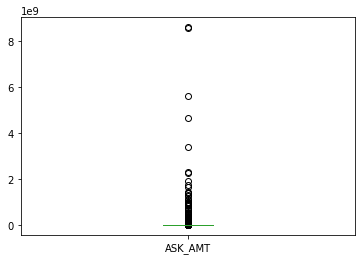

In [17]:
application_df.ASK_AMT.plot(kind='box')

In [18]:
# categorize asked amount to bins
ask_amount_bins = [0, 5000, 15000, 50000, 200000, 500000, 9000000000]
bin_names = ['<5000', '5000-15000', '15000-50000', '50000-200000', '200000-500000', '>500000']
application_df['ask_amount_bins'] = pd.cut(application_df.ASK_AMT, ask_amount_bins, labels=bin_names)
application_df.drop(columns='ASK_AMT', inplace=True)
application_df.head()

,STATUS,IS_SUCCESSFUL,APPLICATION_TYPE_Other,APPLICATION_TYPE_T10,APPLICATION_TYPE_T19,APPLICATION_TYPE_T3,APPLICATION_TYPE_T4,APPLICATION_TYPE_T5,APPLICATION_TYPE_T6,APPLICATION_TYPE_T7,...,INCOME_AMT_10000-24999,INCOME_AMT_100000-499999,INCOME_AMT_10M-50M,INCOME_AMT_1M-5M,INCOME_AMT_25000-99999,INCOME_AMT_50M+,INCOME_AMT_5M-10M,SPECIAL_CONSIDERATIONS_N,SPECIAL_CONSIDERATIONS_Y,ask_amount_bins
0,1,1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,<5000
1,1,1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,50000-200000
2,1,0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,<5000
3,1,1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,5000-15000
4,1,1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,50000-200000


In [19]:
application_df.ask_amount_bins.value_counts()

<5000            25398
50000-200000      2552
>500000           2227
15000-50000       2011
200000-500000     1175
5000-15000         936
Name: ask_amount_bins, dtype: int64

In [20]:
application_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34299 entries, 0 to 34298
Data columns (total 44 columns):
 #   Column                        Non-Null Count  Dtype   
---  ------                        --------------  -----   
 0   STATUS                        34299 non-null  int64   
 1   IS_SUCCESSFUL                 34299 non-null  int64   
 2   APPLICATION_TYPE_Other        34299 non-null  float64 
 3   APPLICATION_TYPE_T10          34299 non-null  float64 
 4   APPLICATION_TYPE_T19          34299 non-null  float64 
 5   APPLICATION_TYPE_T3           34299 non-null  float64 
 6   APPLICATION_TYPE_T4           34299 non-null  float64 
 7   APPLICATION_TYPE_T5           34299 non-null  float64 
 8   APPLICATION_TYPE_T6           34299 non-null  float64 
 9   APPLICATION_TYPE_T7           34299 non-null  float64 
 10  APPLICATION_TYPE_T8           34299 non-null  float64 
 11  AFFILIATION_CompanySponsored  34299 non-null  float64 
 12  AFFILIATION_Family/Parent     34299 non-null  

In [21]:
application_df['ask_amount_bins'] = application_df['ask_amount_bins'].astype('object')

In [22]:
# Encode categorical columns
application_cat = application_df.dtypes[application_df.dtypes == 'object'].index.tolist()
enc = OneHotEncoder(sparse=False)
encode_df = pd.DataFrame(enc.fit_transform(application_df[application_cat]))
encode_df.columns = enc.get_feature_names(application_cat)

# Merge one-hot encoded features and drop the originals
application_df = application_df.merge(encode_df, left_index=True, right_index=True)
application_df = application_df.drop(columns=application_cat)
application_df.head()

,STATUS,IS_SUCCESSFUL,APPLICATION_TYPE_Other,APPLICATION_TYPE_T10,APPLICATION_TYPE_T19,APPLICATION_TYPE_T3,APPLICATION_TYPE_T4,APPLICATION_TYPE_T5,APPLICATION_TYPE_T6,APPLICATION_TYPE_T7,...,INCOME_AMT_50M+,INCOME_AMT_5M-10M,SPECIAL_CONSIDERATIONS_N,SPECIAL_CONSIDERATIONS_Y,ask_amount_bins_15000-50000,ask_amount_bins_200000-500000,ask_amount_bins_5000-15000,ask_amount_bins_50000-200000,ask_amount_bins_<5000,ask_amount_bins_>500000
0,1,1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,1,1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,1,0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,1,1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,1,1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [23]:
# Split our preprocessed data into our features and target arrays
y = application_df['IS_SUCCESSFUL'].values
X = application_df.drop('IS_SUCCESSFUL', 1).values

# Split the preprocessed data into a training and testing dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=40)

# Create a StandardScaler instances
scaler = StandardScaler()

# Fit the StandardScaler
X_scaler = scaler.fit(X_train)

# Scale the data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [24]:
# Define the model - deep neural net, i.e., the number of input features and hidden nodes for each layer.
nn_3 = tf.keras.models.Sequential()

# First hidden layer
nn_3.add(tf.keras.layers.Dense(units=80, activation='relu', input_dim=45))

# Second hidden layer
nn_3.add(tf.keras.layers.Dense(units=30, activation='relu'))

# Output layer
nn_3.add(tf.keras.layers.Dense(units=1, activation='sigmoid'))

# Check the structure of the model
nn_3.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 80)                3680      
_________________________________________________________________
dense_7 (Dense)              (None, 30)                2430      
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 31        
Total params: 6,141
Trainable params: 6,141
Non-trainable params: 0
_________________________________________________________________


In [25]:
# Import checkpoint dependencies
import os
from tensorflow.keras.callbacks import ModelCheckpoint

# Define the checkpoint path and filenames
os.makedirs("checkpoints",exist_ok=True)
checkpoint_path = "checkpoints/weights_opt.{epoch:02d}.hdf5"

steps_per_epoch = 804

# Create a callback that saves the model's weights every 5 epochs
cp_callback = ModelCheckpoint(
    filepath=checkpoint_path,
    verbose=1,
    save_weights_only=True,
    save_freq=5*steps_per_epoch)

In [26]:
# Compile the model
nn_3.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

In [28]:
# Train the model
fit_model = nn_3.fit(X_train_scaled, y_train, epochs=100, callbacks=[cp_callback])

Epoch 1/100


ValueError: in user code:

    /Users/chandnisharma/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/keras/engine/training.py:853 train_function  *
        return step_function(self, iterator)
    /Users/chandnisharma/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/keras/engine/training.py:842 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /Users/chandnisharma/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/tensorflow/python/distribute/distribute_lib.py:1286 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /Users/chandnisharma/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/tensorflow/python/distribute/distribute_lib.py:2849 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /Users/chandnisharma/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/tensorflow/python/distribute/distribute_lib.py:3632 _call_for_each_replica
        return fn(*args, **kwargs)
    /Users/chandnisharma/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/keras/engine/training.py:835 run_step  **
        outputs = model.train_step(data)
    /Users/chandnisharma/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/keras/engine/training.py:787 train_step
        y_pred = self(x, training=True)
    /Users/chandnisharma/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/keras/engine/base_layer.py:1020 __call__
        input_spec.assert_input_compatibility(self.input_spec, inputs, self.name)
    /Users/chandnisharma/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/keras/engine/input_spec.py:254 assert_input_compatibility
        ' but received input with shape ' + display_shape(x.shape))

    ValueError: Input 0 of layer sequential_2 is incompatible with the layer: expected axis -1 of input shape to have value 45 but received input with shape (None, 48)


In [29]:
# Evaluate the model using the test data
model_loss, model_accuracy = nn_3.evaluate(X_test_scaled,y_test,verbose=2)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

ValueError: in user code:

    /Users/chandnisharma/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/keras/engine/training.py:1330 test_function  *
        return step_function(self, iterator)
    /Users/chandnisharma/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/keras/engine/training.py:1320 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /Users/chandnisharma/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/tensorflow/python/distribute/distribute_lib.py:1286 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /Users/chandnisharma/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/tensorflow/python/distribute/distribute_lib.py:2849 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /Users/chandnisharma/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/tensorflow/python/distribute/distribute_lib.py:3632 _call_for_each_replica
        return fn(*args, **kwargs)
    /Users/chandnisharma/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/keras/engine/training.py:1313 run_step  **
        outputs = model.test_step(data)
    /Users/chandnisharma/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/keras/engine/training.py:1267 test_step
        y_pred = self(x, training=False)
    /Users/chandnisharma/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/keras/engine/base_layer.py:1020 __call__
        input_spec.assert_input_compatibility(self.input_spec, inputs, self.name)
    /Users/chandnisharma/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/keras/engine/input_spec.py:254 assert_input_compatibility
        ' but received input with shape ' + display_shape(x.shape))

    ValueError: Input 0 of layer sequential_2 is incompatible with the layer: expected axis -1 of input shape to have value 45 but received input with shape (None, 48)


In [30]:
# Export  model to HDF5 file
nn_3.save("AlphabetSoupCharity_Optimization.h5")